In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np

In [2]:
# Consider the eggo-Facebook dataset, available at https://snap.stanford.edu/data/ego-Facebook.html
ego_fb_edges_fn = "../ego_facebook/facebook_combined.txt"
edges = [(0,1), (0,2), (0,3), (1,2), (2,1)]
with open(ego_fb_edges_fn, "r") as file:
    lines = [ line.strip().split(" ") for line in file.readlines() ]
    edges = [ (int(n1), int(n2)) for (n1, n2) in lines ]
g2 = nx.Graph(edges)
#g2_coords = nx.spring_layout(g2)
print(g2)
degree_cent = nx.degree_centrality(g2)
#close_cent = nx.closeness_centrality(g2)
#between_cent = nx.betweenness_centrality(g2)

Graph with 4039 nodes and 88234 edges


In [36]:
# code modified from: https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/
def show_linear_regression(x, y):
    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    fit = p(x)
    
    # get the coordinates for the fit curve
    c_y = [np.min(fit), np.max(fit)]
    c_x = [np.min(x), np.max(x)]
    
    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]
    
    # calculate the y-error (residuals)
    y_err = y - p_y
    
    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)
    
    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)                 # mean of x
    n = len(x)                          # number of samples in origional fit
    t = 2.31                            # appropriate t value (where n=9, two tailed 95%)
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
    
    confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
                ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[0]
    
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)
    
    # set-up the plot
    """ plt.axes().set_aspect('equal') """
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Linear regression and confidence limits')
    
    # plot sample data
    plt.plot(x, y,'bo',label='Sample observations')
    
    # plot line of best fit
    plt.plot(c_x, c_y,'r-',label='Regression line')
    
    # plot confidence limits
    plt.plot(p_x, lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x, upper,'b--',label='Upper confidence limit (95%)')
    
    # set coordinate limits
    """ plt.xlim(0,11)
    plt.ylim(0,11) """

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)
    
    plt.show()

In [2]:
def plot_power_law_fit(values, title='power law fit check', figsize=(5,5), ci=0.95):
    dc_min, dc_max = min(values), max(values)
    X = np.logspace(np.log10(dc_min), np.log10(dc_max), 40) # generate log distributed x values
    Y = [len([dc for dc in values if dc <= x]) for x in X] # cumulative sum

    lnX, lnY = np.log(X), np.log(Y)

    """ show_linear_regression(lnX, lnY) """
    #sns.regplot(x=lnX, y=lnY, ci=90)
    #return

    regr = LinearRegression().fit(lnX.reshape(-1,1), lnY)
    lnY_pred = regr.predict(lnX.reshape(-1,1))

    lnX_con = sm.add_constant(lnX)
    lr = sm.OLS(lnY, lnX_con).fit()
    y_int, grad = lr.params
    conf_interval = lr.conf_int(1-ci)
    (y_int_lower, y_int_upper), _ = conf_interval
    lnY_pred = lr.predict(lnX_con)

    _, ax = plt.subplots(figsize=figsize)
    ax.plot(lnX, lnY, 'r.', label='samples')
    ax.plot(lnX, y_int + grad*lnX, 'g', label='regression line')
    ax.plot(lnX, y_int_lower + grad*lnX, 'b', label='lower ci ({})'.format(ci))
    ax.plot(lnX, y_int_upper + grad*lnX, 'b', label='upper ci ({})'.format(ci))

    ax.set_title(title)
    plt.ylabel('log(n)')
    plt.xlabel('log(p_k)')

    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    plt.show()

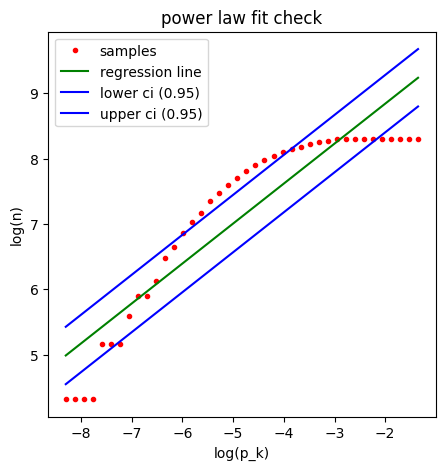

In [46]:
values = list(degree_cent.values())
plot_power_law_fit(values)

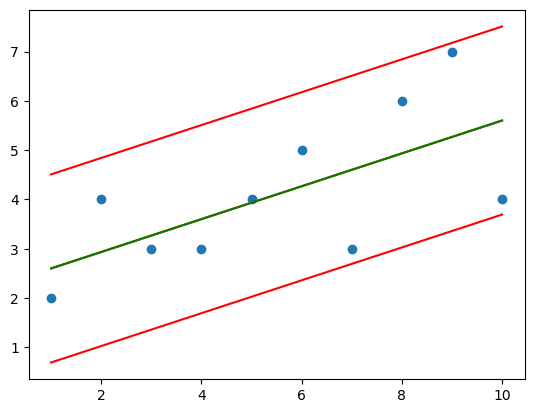

In [7]:
x = np.array([1,2,3,4,5,6,7,8,9,10])#.reshape(-1,1)
y = np.array([2,4,3,3,4,5,3,6,7,4])

#show_linear_regression(x, y)
#regr = LinearRegression().fit(x.reshape(-1,1), y)
#y_pred = regr.predict(x.reshape(-1,1))

alpha = 0.05
x_con = sm.add_constant(x)
lr = sm.OLS(y, x_con).fit()
y_int, grad = lr.params
conf_interval = lr.conf_int(alpha)
(y_int_lower, y_int_upper), _ = conf_interval
y_pred = lr.predict(x_con)

plt.scatter(x, y)
plt.plot(x, y_pred, 'r')
plt.plot(x, y_int + x*grad, 'g')
plt.plot(x, y_int_lower + x*grad, 'r')
plt.plot(x, y_int_upper + x*grad, 'r')
plt.show()

<Axes: >

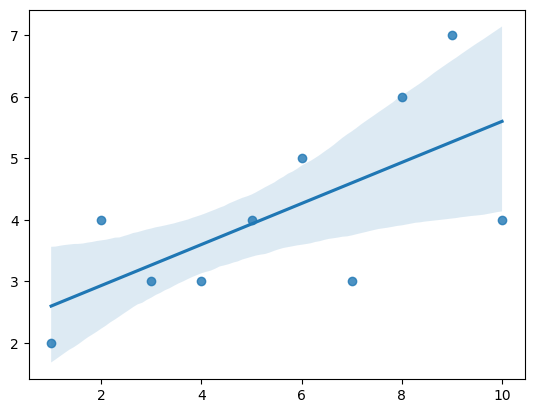

In [6]:
import seaborn as sns 
sns.regplot(x=x, y=y, ci=90)